# Mind Model

## 0 Import Libraries

### 0.1 Standard Library

In [ ]:
import gc
import importlib
import os
import random
import shutil
import subprocess
from typing import Any, Callable

### 0.2 External Libraries

In [ ]:
import cv2
import dill
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import BatchNormalization, concatenate, Conv2D, Conv2DTranspose, Dropout, Input, MaxPooling2D
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, BinaryIoU, Precision, Recall
from keras.models import load_model, Model
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.src.engine.keras_tensor import KerasTensor
from keras.utils import Sequence
from keras_tuner import BayesianOptimization, HyperParameters, Objective, Tuner
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf

## 1 Setup

### 1.1 Check and Configure Google Colab

In [ ]:
WORKDIR_PATH = "../"
try:
    subprocess.run(["pip", "install", "keras-tuner"])
    google_module = importlib.import_module("google.colab.drive")
    DRIVE_PATH = "/content/drive/"
    getattr(google_module, "mount")(DRIVE_PATH)
    WORKDIR_PATH = DRIVE_PATH + "MyDrive/POPBL 5/Modeloa/colab/"
except ImportError:
    pass

### 1.2 Set Global Constants

In [ ]:
CACHE_DIR = WORKDIR_PATH + ".cache/"
DATASET_DIR = WORKDIR_PATH + "dataset/"
LOAD_SESSION = False
MODEL_DIR = WORKDIR_PATH + "src/mind/model/"
MODEL_NAME = "mind.keras"
RANDOM_STATE = 42
SESSION_NAME = "mind-session.db"

### 1.3 Load Session

In [ ]:
if LOAD_SESSION:
    dill.load_session(SESSION_NAME)

### 1.4 Setup the GPU

#### 1.4.1 Set Max VRAM Size

In [ ]:
VRAM = 2048 # Google Colab Free Tier = 15360, Eñaut = 2048, Txillu = 8192, Gaizka = 16376

#### 1.4.2 Configure VRAM Usage

Attempts to allocate only as much GPU memory as needed for the runtime allocations: it starts out allocating very little memory, and as the program gets run and more GPU memory is needed, the GPU memory region is extended for the TensorFlow process. The GPU memory is limited by the constant `VRAM`

In [ ]:
GPU_LIST = tf.config.list_physical_devices("GPU")
if GPU_LIST:
    try:
        for gpu in GPU_LIST:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=VRAM)])
        logical_gpu_list = tf.config.list_logical_devices("GPU")
        print(f"Available GPUs: {len(GPU_LIST)} Physical GPUs, {len(logical_gpu_list)} Logical GPUs")
    except RuntimeError as e:
        print(f"Error: {e}")

### 1.5 Disable Garbage Collection

Because of the resource limit in Google Colab and on our own computers, we will manually free the resources, by calling the garbage collector. For that we will disable the garbage collector, because if the garbage collection is running and it is called, that will cause undefined behaviour.

In [ ]:
gc.disable()
gc.collect()

## 2 Import Data

### 2.1 Load Data

#### 2.1.1 Helper Function

In [ ]:
def load_data(directory: str) -> pd.DataFrame:
    image_paths = [os.path.join(directory, file_name) for file_name in os.listdir(directory) if "_mask" not in file_name]
    masks = [cv2.imread(path.replace(".tif", "_mask.tif"), cv2.IMREAD_GRAYSCALE) for path in image_paths]
    return pd.DataFrame({
        "image_names": [os.path.split(path)[1] for path in image_paths],
        "images": [cv2.imread(path) for path in image_paths],
        "masks": masks,
        "diagnosis": [np.any(mask) for mask in masks],
    })

#### 2.1.2 Load Data

In [ ]:
dataset = load_data(DATASET_DIR)

### 2.2 Visualize Data

#### 2.2.1 Helper Function

In [ ]:
def visualize_dataset_classes(dataframe: pd.DataFrame, title: str, number_offset: int, figure_size: tuple[float, float] = (6, 6)) -> None:
    counts = dataframe["diagnosis"].value_counts()
    plt.figure(figsize=figure_size)
    plt.title(title)
    plt.bar(counts.index, counts, color=['b', 'r'])
    plt.ylabel("Image Count")
    plt.xticks(counts.index, ["No Tumor", "Tumor"], rotation = 0)

    for i, count in enumerate(counts):
        plt.annotate(str(count), (i, count + number_offset), ha="center", fontweight="bold")

    plt.show()
    plt.close()

#### 2.2.2 Visualize Entire Dataset

In [ ]:
visualize_dataset_classes(dataset, "Complete Dataset", 15)

#### 2.2.3 Clean Up

In [ ]:
gc.collect()

### 2.3 Split Data

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=RANDOM_STATE)

#### 2.3.1 Visualize Train Data

In [ ]:
visualize_dataset_classes(train_dataset, "Train Dataset", 15)

#### 2.3.2 Visualize Test Data

In [ ]:
visualize_dataset_classes(test_dataset, "Test Dataset", 10)

#### 2.3.3 Clean Up

In [ ]:
gc.collect()

### 2.4 Create Generators

#### 2.4.1 Define Generator Class

When training the model, all the images are loaded to the GPUs VRAM, and it
gets full very quickly. To avoid that, the following generator feeds the model, by batches, from RAM.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, dataframe: pd.DataFrame, input_columns: list, output_column: str, batch_size: int):
        self.dataframe = dataframe
        self.input_columns = input_columns
        self.output_column = output_column
        self.batch_size = batch_size
        self.x_batch = np.zeros((batch_size, 256, 256, 3))
        self.y_batch = np.zeros((batch_size, 256, 256))

    def __len__(self) -> int:
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __getitem__(self, i: int) -> tuple[np.ndarray, np.ndarray]:
      batch_data = self.dataframe.iloc[i * self.batch_size:(i + 1) * self.batch_size]
      batch_input_shape = batch_data[self.input_columns].values.squeeze().shape
      batch_output_shape = batch_data[self.output_column].values.shape
      np.stack(batch_data[self.input_columns].values.squeeze(), out=self.x_batch[:batch_input_shape[0], :, :, :]) # type: ignore
      np.stack(batch_data[self.output_column].values, out=self.y_batch[:batch_output_shape[0], :, :]) # type: ignore
      return self.x_batch, self.y_batch

## 3 Data Preprocessing

### 3.1 Data Augmentation

Artificially increase the size of a dataset by applying various transformations to the existing data samples. The goal is to diversify the dataset and improve the generalization and robustness of the model. Data augmentation is commonly used in computer vision tasks, such as image classification and object detection, to create variations of the input data without collecting new samples.

The test set is used to try to estimate how your method works on real world data, thus it should only contain real world data. Adding augmented data will not improve the accuracy of the validation. It will at best say something about how well your method responds to the data augmentation, and at worst ruin the validation results and interpretability.

#### 3.1.1 Set Constants

In [ ]:
AUGMENTATION_PERCENTAGE = 1.00

#### 3.1.2 Helper Function

In [ ]:
def augment_from_image(image_names: str, image: np.ndarray, mask: np.ndarray, diagnosis: bool, random_state: int | None = None) -> tuple[str, np.ndarray, np.ndarray, bool]:
    height, width = image.shape[:2]
    random.seed(random_state)
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), random.randint(30, 330), 1.0)
    techniques = [
        lambda img: cv2.flip(img, 1),   # Mirror
        lambda img: cv2.flip(img, 0),   # Upside down
        lambda img: cv2.flip(img, -1),  # Mirror and Upside down
        lambda img: cv2.warpAffine(img, rotation_matrix, (width, height)) # Rotate
    ]
    technique = random.choice(techniques)
    return image_names, technique(image), technique(mask), diagnosis

#### 3.1.3 Augment Training Data

In [ ]:
split_point = int(len(train_dataset) * AUGMENTATION_PERCENTAGE)
augmented_data = train_dataset.iloc[:split_point, :].apply(lambda row: pd.Series(augment_from_image(row["image_names"], row["images"], row["masks"], row["diagnosis"], random_state=RANDOM_STATE)), axis=1, result_type="broadcast").astype({"image_names": str, "images": object, "masks": object, "diagnosis": bool})
train_dataset = pd.concat([train_dataset, augmented_data], copy=False)

#### 3.1.4 Shuffle

In [ ]:
train_dataset.update(train_dataset.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True))
train_dataset = train_dataset.astype({"image_names": str, "images": object, "masks": object, "diagnosis": bool})

#### 3.1.5 Print Summary

Here we can see, that we augmented the training data size.

In [ ]:
train_dataset.info()

#### 3.1.6 Visualize Augmented Data

In [ ]:
visualize_dataset_classes(train_dataset, "Augmented Train Dataset", 15)

#### 3.1.7 Clean Up

In [ ]:
gc.collect()

### 3.2 Normalize Images

Set all pixel value range to [0, 1]. The primary reasons for normalizing images in CNNs are:

1. **Improved Convergence**: Normalizing images helps the optimization algorithm converge faster during training. Normalization brings the pixel values to a common scale, preventing large input values from dominating the learning process. This can lead to faster convergence and more stable training.

2. **Gradient Descent Stability**: During backpropagation, the optimization algorithm adjusts the weights of the neural network based on the gradients of the loss with respect to the weights. Normalizing the input data helps ensure that the gradients are within a reasonable range. This can prevent issues like exploding or vanishing gradients, which can hinder the training process.

3. **Model Robustness**: Normalization can make the model more robust to variations in illumination and contrast. By bringing the pixel values to a standard scale, the network becomes less sensitive to changes in lighting conditions or differences in pixel intensity across different images.

4. **Generalization**: Normalization aids in generalization by making the model less dependent on the specific characteristics of the training data. It allows the model to learn patterns and features that are more transferable across different datasets.

5. **Compatibility with Activation Functions**: Some activation functions, such as the sigmoid and tanh functions, perform better when the input values are within a certain range. Normalizing the data helps ensure that the inputs to these functions fall within the regions where they exhibit desirable properties.

In [ ]:
train_dataset["images"].update(train_dataset["images"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)))
test_dataset["images"].update(test_dataset["images"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

### 3.3 Clip Masks

Each pixel in the mask has a value of either 0 or 255. This means, that if the pixel value is 0, the same pixel position in the associated image is not part of a tumor, and if its 255, then it is part of a tumor. To better represent that, the mask is converted to an array of boolean values, by replacing anything greater than 1 as 1.

In [ ]:
train_dataset["masks"].update(train_dataset["masks"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)))
test_dataset["masks"].update(test_dataset["masks"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)))

## 4 Modelling

### 4.1 Set Up

#### 4.1.1 Define Constants

In [ ]:
BATCH_SIZE = 4 # Google Colab = 32, Eñaut = 4, Txillu = 16, Gaizka = 34
EPOCHS = 100
NUM_FOLDS = 10

#### 4.1.2 Split Data

In [ ]:
final_train, final_validation = train_test_split(train_dataset, test_size=0.2, random_state=RANDOM_STATE)

#### 4.1.3 Create Generators

In [ ]:
train_generator = DataGenerator(train_dataset, ["images"], "mask", BATCH_SIZE)
test_generator = DataGenerator(test_dataset, ["images"], "mask", BATCH_SIZE)
final_train_generator = DataGenerator(final_train, ["images"], "mask", BATCH_SIZE)
final_validation_generator = DataGenerator(final_validation, ["images"], "mask", BATCH_SIZE)

### 4.2 Model

We will use the **U-Net** architecture, which is a convolutional neural network that was developed for biomedical image segmentation. It maintains a relatively low parameter count, making it computationally efficient and accessible to our hardware. The architecture's ability to perform well with limited annotated data was also a significant factor in our decision to choose it.



The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. In very simple words, U-Net breaks the images down with the Convolution operations and re-creates it again with De-convolution operations. The expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture.

![1 Rmo71TyPxvLLM4FnlH5MDg.jpg](<attachment:1 Rmo71TyPxvLLM4FnlH5MDg.jpg>)
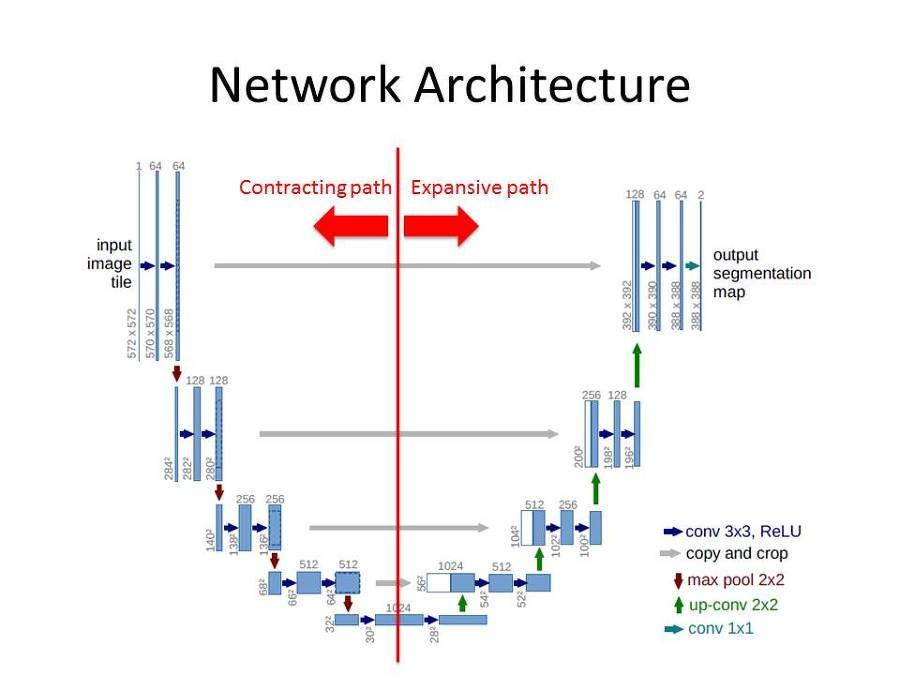

#### 4.2.1 Helper Functions

##### 4.2.1.1 Convolution Block

The convolution operation calculates the sum of the element-wise multiplication between the input matrix and kernel matrix.

It can be visualized as follows:

![1 QgiVWSD6GscHh9nt55EfXg.gif](<attachment:1 QgiVWSD6GscHh9nt55EfXg.gif>)

**Sources:**
- [Understanding Semantic Segmentation with UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47#:~:text=8.-,UNET%20Architecture%20and%20Training,for%20Bio%20Medical%20Image%20Segmentation.&text=Thus%20it%20is%20an%20end,accept%20image%20of%20any%20size)
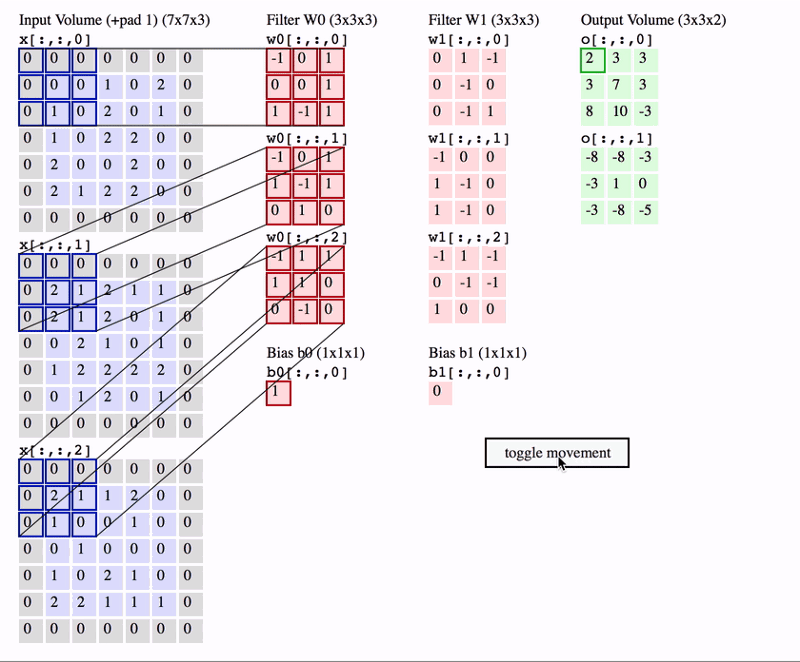

In [ ]:
def convolution_block(inputs: Any, filters: int, dropout_rate: float, kernel_size: tuple[int, int] = (3, 3), activation: str = "relu", normalize: bool = True) -> Any:
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(inputs)
    x = BatchNormalization()(x) if normalize else x
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x) if normalize else x
    x = Dropout(dropout_rate)(x) if dropout_rate > 0 else x
    return x

##### 4.2.1.2 Encoder

Add explication

In [ ]:
def encoder_block(inputs: KerasTensor, filters: int, dropout_rate: float, pool_size: tuple[int, int] = (2, 2)) -> tuple[Any, Any]:
    conv = convolution_block(inputs, filters, dropout_rate)
    pool = MaxPooling2D(pool_size)(conv)
    return conv, pool

##### 4.2.1.3 Decoder

Add explication

In [ ]:
def decoder_block(inputs: KerasTensor, skip_features: KerasTensor, filters: int, upsample_size: tuple[int, int] = (2, 2), dropout_rate: float = 0.2):
    x = Conv2DTranspose(filters, upsample_size, strides=(2, 2), padding = "same")(inputs)
    x = concatenate([x, skip_features], axis=-1)
    x = convolution_block(x, filters, dropout_rate=dropout_rate)
    return x

##### 4.2.1.4 Unet Builder

Add explication

In [ ]:
def unet_builder(filters: int = 64, input_shape: tuple[int, int, int] = (256, 256, 3), num_classes: int = 1, dropout_rate: float = 0.2) -> Model:
    # Input
    input_image = Input(input_shape)

    # Encoder
    conv1, pool = encoder_block(input_image, filters, dropout_rate = dropout_rate) # type: ignore
    conv2, pool = encoder_block(pool, filters * 2, dropout_rate = dropout_rate)
    conv3, pool = encoder_block(pool, filters * 4, dropout_rate = dropout_rate)

    # Bottleneck
    bottleneck = convolution_block(pool, filters * 8, dropout_rate = dropout_rate)

    # Decoder
    up = decoder_block(bottleneck, conv3, filters * 4, dropout_rate = dropout_rate)
    up = decoder_block(up, conv2, filters * 2, dropout_rate = dropout_rate)
    up = decoder_block(up, conv1, filters, dropout_rate = dropout_rate)

    # Output layer
    output = Conv2D(num_classes, 1, activation = "sigmoid")(up)
    
    return Model(inputs=input_image, outputs=output)

#### 4.2.2 Define Loss Function

A loss function, also known as a cost function or objective function, is a mathematical measure used in machine learning to quantify the difference between the predicted values of a model and the actual values of the target variable. The goal of training a machine learning model is to minimize this loss function.

In simpler terms, the loss function tells the model how well it is performing by calculating the extent of its errors. The model aims to minimize this calculated loss during the training process.

**Why Binary Crossentropy?**

Binary Crossentropy is commonly used as a loss function in binary image segmentation problems because it is well-suited for tasks where the goal is to classify each pixel in an image into one of two classes: foreground (object) or background. In binary image segmentation, the output of the model is typically a probability map where each pixel represents the likelihood of belonging to the foreground class.

Binary Crossentropy is designed for binary classification problems, where there are only two possible classes. In binary image segmentation, each pixel is assigned a probability score between 0 and 1 for being part of the foreground class. It measures the dissimilarity between the predicted probability distribution and the actual distribution of the target (ground truth), by heavily penalizing predictions that are confidently wrong, making it suitable for problems where accurate pixel-wise predictions are crucial.

**Sources**
- [Understanding binary cross-entropy / log loss: a visual explanation](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
- [ML Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

In [ ]:
loss = BinaryCrossentropy()

#### 4.2.3 Define Metrics

**Binary Accuracy**

Binary accuracy calculates the proportion of correctly classified instances out of the total number of instances in the dataset, in other words, it measures the percentage of instances for which the model's predictions match the actual labels:

$$
\text{Binary Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

It is commonly used when the dataset is balanced, meaning that there is an approximately equal number of instances in each class. In situations where one class significantly outnumbers the other, accuracy might be misleading, which is our case. Because of the mask pixels being mostly black (value 0) and the majority of the photographs not having tumors, our dataset is very inbalanced. Due to this, this metric is very misleading, as even a completely black mask, gives a very high accuracy.

**Precision**

Precision is a metric used in binary and multiclass classification to evaluate the accuracy of positive predictions made by a model. It is particularly relevant when the goal is to minimize false positives. Precision is calculated as the ratio of true positive predictions to the total number of positive predictions made by the model, and it is expressed by the following formula:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$$

A high precision indicates that the model is accurate when it predicts positive instances, while a low precision suggests that the model is making more false positive errors.

Precision is especially important in situations where the cost or impact of false positives is high, such as our case, in which we don't want to incorrectly detect brain tumors.

**Recall**

Recall, also known as Sensitivity or True Positive Rate, is a metric used in binary and multiclass classification to evaluate the ability of a model to capture all the positive instances. It measures the proportion of actual positive instances that the model correctly identifies. Recall is calculated using the following formula:

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$$

A high recall indicates that the model is effective at identifying a large portion of the positive instances, even if it means it may also have a higher number of false positives.

Recall is particularly important in situations where missing positive instances (false negatives) is more critical than incorrectly identifying negative instances (false positives). In our case, not detecting a brain tumor might lead to a patient death, so having a high recall is benefitial for us.

**Binary IoU**

Binary Intersection over Union (IoU) (or Jaccard Index) is a metric commonly used in image segmentation  tasks to evaluate the accuracy of predictions. It measures the overlap between the predicted region and the ground truth region, providing an indication of how well the predicted and actual regions align.

For binary segmentation tasks, the binary IoU is calculated using the following formula:

$$
\text{IoU} = \frac{\text{Intersection of Predicted and Ground Truth Regions}}{\text{Union of Predicted and Ground Truth Regions}}
$$

In simpler terms, it measures the ratio of the area of overlap between the predicted and true regions to the total area covered by both regions. The intersection is the area where the predicted and ground truth regions overlap, and the union is the combined area covered by both regions. A higher IoU score indicates better alignment between the predicted and true regions.

Binary IoU is particularly useful in tasks where spatial accuracy is crucial, such as in medical image segmentation. It provides a more precise evaluation than accuracy alone, especially when dealing with imbalanced datasets where one class may be much more prevalent than the other.

In [ ]:
metrics = [
    BinaryAccuracy(),
    Precision(),
    Recall(),
    BinaryIoU()
]

#### 4.2.4 Define Possible Optimizers

**Optimizers**

The ultimate goal of ML model is to reach the minimum of the loss function. An optimizer is an algorithm or method that is used to adjust the parameters of a model to minimize a loss function.

They tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, optimizers tweak and adjust your model to make it as accurate as possible by playing around with its weights. The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction.

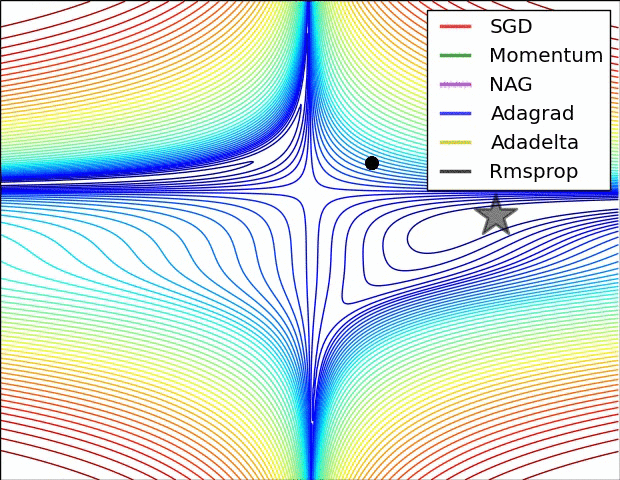

**Learning Rate**

During training, the algorithm attempts to minimize the loss function by adjusting the model parameters. The learning rate controls the size of the steps taken in the direction that reduces the value of the loss function. A too-small learning rate may cause the algorithm to converge very slowly, while a too-large learning rate can lead to overshooting and potentially prevent the model from converging.


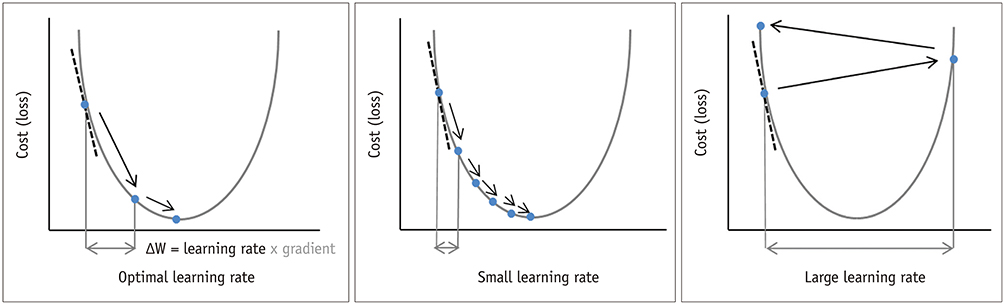


**Sources:**

- [ML Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html)
- [Interactive Visualization of Optimization Algorithms in Deep Learning](https://emiliendupont.github.io/2018/01/24/optimization-visualization/)
- [Optimizers in Machine Learning](https://medium.com/nerd-for-tech/optimizers-in-machine-learning-f1a9c549f8b4)
- [How to Use Learning Rate Annealing with Neural Networks?](https://productivityhub.org/2021/12/09/how-to-use-learning-rate-annealing-with-neural-networks/)

In [ ]:
possible_optimizers = ["adam", "rsmprop", "sgd", "nadam"]

#### 4.2.5 Define Training Callbacks

Callbacks refer to functions or objects that are called at specific points during the training process of a model. These callbacks provide a way to customize and extend the behavior of the training procedure by executing additional actions, monitoring the training progress, or making dynamic adjustments based on certain conditions. 

Used callbacks:

- **ModelCheckpoint:** Save the model's weights to a file at specific intervals during training. This ensures that if the training process is interrupted, you can resume from the last saved checkpoint rather than starting from scratch.

- **EarlyStopping:** Monitor a certain metric (val_binary_io_u) and stop the training process early if the performance on the validation set does not improve or starts deteriorating. This helps prevent overfitting and saves computational resources.

- **ReduceLROnPlateau:** Dynamically adjust the learning rate during training. This can be useful for improving convergence or dealing with oscillations in the loss landscape.

In [ ]:
def generate_callbacks(monitoring_metric: str, mode: str, checkpoint_dir: str | None, checkpoint_name: str | None, early_stopping_patience: int = 10, lr_reduction_patience: int | None = 3) -> list[Callback]:
    callbacks = []
    
    callbacks.append(EarlyStopping(monitor=monitoring_metric, patience=early_stopping_patience, verbose=1, mode=mode, restore_best_weights=True))
    
    if checkpoint_name and checkpoint_dir:
        callbacks.append(ModelCheckpoint(checkpoint_dir + checkpoint_name, monitor=monitoring_metric, verbose=1, save_best_only=True, mode=mode))
    
    if lr_reduction_patience:
        callbacks.append(ReduceLROnPlateau(factor=0.1, patience=lr_reduction_patience, min_lr=int(1e-7), verbose=1))

    return callbacks

### 4.3 Hyperparameter Tuning

#### 4.3.1 Helper Functions

##### 4.3.1.1 Prepare Model for Tuning

In [ ]:
def prepare_unet_tuning(hp: HyperParameters) -> Model:
    learning_rate: float | None = hp.Float("learning_rate", min_value=1e-5, max_value=1, step=10, sampling="log")
    optimizer_str = hp.Choice("optimizer", values=possible_optimizers)
    filters = hp.Int("filters", min_value=16, max_value=128, step=2, sampling="log")
    dropout = hp.Float("dropout", min_value=0, max_value=1, step=0.2)
    optimizer = None

    if optimizer_str == "adam":
        optimizer = Adam(learning_rate=learning_rate) if learning_rate else Adam()
    elif optimizer_str == "nadam":
        optimizer = Nadam(learning_rate=learning_rate) if learning_rate else Nadam()            
    elif optimizer_str == "sgd":
        optimizer = SGD(learning_rate=learning_rate) if learning_rate else SGD()
    else:
        optimizer = RMSprop(learning_rate=learning_rate) if learning_rate else RMSprop()

    unet_model = unet_builder(filters if filters else 64, dropout_rate=dropout if dropout else 0.2)
    unet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return unet_model

##### 4.3.1.2 Create Model Tuner

TODO(Eñaut): esplikatu

In [ ]:
def create_tuner(model_preparer: Callable[[HyperParameters], Model], objective: Objective, max_trials: int = 10, seed: int | None = None) -> Tuner:
    return BayesianOptimization(
        hypermodel=model_preparer,
        directory=CACHE_DIR,
        project_name="hyperparameter-tuner",
        objective=objective,
        max_trials=max_trials,
        seed=seed
    )

#### 4.3.2 Create Tuner

In [ ]:
unet_tuner = create_tuner(prepare_unet_tuning, Objective("val_binary_io_u", direction="max"), seed=RANDOM_STATE, max_trials=15)

#### 4.3.3 Print Search Space Summary

In [ ]:
unet_tuner.search_space_summary()

#### 4.3.4 Search Hyperparameters

In [ ]:
unet_tuner.search(x=final_train_generator, 
                  validation_data=final_validation_generator, 
                  epochs=EPOCHS, 
                  steps_per_epoch=len(final_train_generator),
                  callbacks=generate_callbacks("val_binary_io_u", "max", None, None, lr_reduction_patience=None),
                  use_multiprocessing=True)

#### 4.3.5 Print Best Hyperparameter

In [ ]:
unet_tuner.get_best_hyperparameters()[0]

#### 4.3.6 Clean Up

In [ ]:
gc.collect()

### 4.4 Cross Validation

#### 4.4.1 Define Cross Validator

We will use K-fold cross-validation. TODO(Eñaut): gehitu zergatia

In [ ]:
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

#### 4.4.2 Define Histories List

In [ ]:
histories = []

#### 4.4.3 Define Results List

In [ ]:
results = []

#### 4.4.4 Train Folds

In [ ]:
for fold, (train_index, validation_index) in enumerate(kfold.split(train_dataset)):
    # Banner
    print('#' * shutil.get_terminal_size().columns)
    print(f"# {fold} FOLD")
    print('#' * shutil.get_terminal_size().columns)

    # Split train-val
    train_set, validation_set = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]
    
    # Create data generators for train and validation sets
    train_generator = DataGenerator(train_set, ["images"], "masks", BATCH_SIZE)
    validation_generator = DataGenerator(validation_set, ["images"], "masks", BATCH_SIZE)

    # Banner
    print('-' * shutil.get_terminal_size().columns)
    print("Training")
    print('-' * shutil.get_terminal_size().columns)

    # Retrieve the best hyperparameters and build model
    unet_model: Model = unet_tuner.hypermodel.build(unet_tuner.get_best_hyperparameters()[0]) # type: ignore

    # Train and save history
    histories.append(unet_model.fit(x=train_generator,
                                    validation_data=validation_generator,
                                    epochs=EPOCHS,
                                    steps_per_epoch=len(train_generator),
                                    callbacks=generate_callbacks("val_binary_io_u", "max", CACHE_DIR + "folds/", f"{str(fold)}_{MODEL_NAME}"),
                                    use_multiprocessing=True))
    
    # Banner
    print('-' * shutil.get_terminal_size().columns)
    print("Evaluation")
    print('-' * shutil.get_terminal_size().columns)

    # Load and evaluate model
    unet_model: Any | Model = load_model(CACHE_DIR + "folds/" + str(fold) + "_" + MODEL_NAME)
    raw_evaluations = unet_model.evaluate(validation_generator)
    results.append(dict(zip(unet_model.metrics_names, raw_evaluations)))
    
    # Clean Up
    gc.collect()

#### 4.4.5 Display Histories

##### 4.4.5.1 Plot Histories

In [ ]:
for i, history in enumerate(histories):
    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys) // 2, figsize=(25, 5))
    fig.suptitle(str(i + 1) + " Fold Results", fontsize=30)
    for k, key in enumerate(list(keys)[:len(keys) // 2]):
        axs[k].plot(range(1, len(history.history[key]) + 1), history.history[key], "g--")
        axs[k].plot(range(1, len(history.history[key]) + 1), history.history["val_" + key], "b-")
        if key == "loss":
            axs[k].plot(np.argmin(history.history["val_" + key]), np.min(history.history["val_" + key]), marker='x', color='r')
        else:
            axs[k].plot(np.argmax(history.history["val_" + key]), np.max(history.history["val_" + key]), marker='x', color='r')
        axs[k].legend(["Training " + key, "Validation " + key, "Best Model"])
    plt.show()

##### 4.4.5.2 Clean Up

In [ ]:
gc.collect()

#### 4.4.6 Model Evaluation

##### 4.4.6.1 Print Fold Results

In [ ]:
for i, result in enumerate(results):
    print('#' * shutil.get_terminal_size().columns)
    print(f"{i + 1} Fold Results")
    for key, value in result.items():
        print(f"{key}: {value}")

##### 4.4.6.2 Print Model Results

In [ ]:
print('#' * shutil.get_terminal_size().columns)
print("Average Model Results")
print('#' * shutil.get_terminal_size().columns)
for metric in unet_model.metrics_names:
    average = np.mean(np.fromiter((result[metric] for result in results), np.float64))
    standard_deviation = np.std(np.fromiter((result[metric] for result in results), np.float64))
    print(f"Metric: {metric}")
    print(f"\tAverage: {average}")
    print(f"\tStandard Deviation: {standard_deviation}")

##### 4.4.6.3 Clean Up

In [ ]:
gc.collect()

### 4.5 Final Model

#### 4.5.1 Split Data

In [ ]:
unet_model: Model = unet_tuner.hypermodel.build(unet_tuner.get_best_hyperparameters()[0]) # type: ignore

#### 4.5.2 Train Model

In [ ]:
unet_model.fit(x=final_train_generator,
               validation_data=final_validation_generator,
               epochs=EPOCHS,
               steps_per_epoch=len(final_validation_generator),
               callbacks=generate_callbacks("val_binary_io_u", "max", MODEL_DIR, MODEL_NAME),
               use_multiprocessing=True)

## 5 Testing

### 5.1 Load Model

In [ ]:
unet_model: Any | Model = load_model(MODEL_DIR + MODEL_NAME)

### 5.2 Evaluate

#### 5.2.1 Make Evaluation

In [ ]:
raw_evaluations = unet_model.evaluate(test_generator)

#### 5.2.2 Save Evaluations

In [ ]:
evaluations = dict(zip(unet_model.metrics_names, raw_evaluations))

#### 5.2.3 Print Evaluations

In [ ]:
print('#' * shutil.get_terminal_size().columns)
print(f"{i + 1} Final Model Results")
for key, value in result.items():
    print(f"{key}: {value}")

### 5.3 Visualize

#### 5.3.1 Reset Indices

In [ ]:
test_dataset.reset_index(drop=True, inplace=True)

#### 5.3.1 Make Predictions

In [ ]:
predictions = unet_model.predict(test_generator)

#### 5.3.2 Plot Images

In [ ]:
for _ in range(25):
    random_row: pd.DataFrame = test_dataset.sample()
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    fig.suptitle(random_row["image_names"].values[0], fontsize=15)
    for i, (ax, title) in enumerate(zip(axes, ["Input image", "Real mask", "Predicted mask", "Predicted Binary Mask", "Blend"])):
        image = random_row["images"].values[0]
        prediction = predictions[random_row.index].squeeze()
        alpha = 0.3
        if i == 0:
            ax.imshow(image)
        elif i == 1:
            ax.imshow(random_row["masks"].values[0], cmap="gray")
        elif i == 2:
            ax.imshow(prediction, cmap="gray")
        elif i == 3:
            ax.imshow(prediction > 0.5, cmap="gray")
        else:
            ax.imshow(cv2.addWeighted(image, 1 - alpha, cv2.cvtColor(prediction, cv2.COLOR_GRAY2BGR), alpha, 0))
        ax.set_axis_off()
        ax.set_title(title)
    plt.show()

## 6 Post Training

### 6.1 Set Constants

In [ ]:
CLEAN_CACHE = False
DUMP_SESSION = True

### 6.2 Clean Folds

In [ ]:
if CLEAN_CACHE:
    try:
        shutil.rmtree(CACHE_DIR)
        print(f"Correctly deleted folder {CACHE_DIR}")
    except Exception as e:
        print(f"Error deleting folder {CACHE_DIR}: {e}")
        

### 6.3 Save Session

In [ ]:
if DUMP_SESSION:
    dill.dump_session(SESSION_NAME)